In [1]:
import pandas as pd
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score,precision_score,accuracy_score,confusion_matrix
from sklearn.decomposition import PCA
import scipy
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from bioinfokit.visuz import cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# MC_visual_confusion_matrix

In [2]:
def MC_visual_confusion_matrix(X_DR, Y_list, export_file=True):
    """
    Figure 4 in the paper performing pairwise comparison from a list of classifiers via visual confusion matrix.
    Example given below is for 3 binary classifiers
    Input X of reduced dimensionality, and a list of tuples that consist of model_name and model_prediction
    """  

    num_models = len(Y_list)
    df=pd.concat([X_DR, pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1])], axis=1, ignore_index=True)
    df.columns=['DR1','DR2', Y_list[0][0], Y_list[1][0], Y_list[2][0]]

    for i1 in range(len(Y_list)):
        for i2 in range(i1+1,len(Y_list)):
            model1_name = Y_list[i1][0]
            model2_name = Y_list[i2][0]
            #print(model1_name, model2_name)
            classes1 = np.unique(Y_list[i1][1])
            classes2 = np.unique(Y_list[i2][1])

            #figure4a
            fig, axs = plt.subplots(len(classes1),len(classes2), figsize = (12,10),sharex=True, sharey=True)
            color=['b','r','goldenrod','g']

            c=-1
            for i in range(len(classes1)):
                for j in range(len(classes2)):
                    c+=1
                    relevant_observations = (df[model1_name]==classes1[i]) & (df[model2_name]==classes2[j])
                    axs[i,j].plot(X_DR.iloc[:,0][relevant_observations], X_DR.iloc[:,1][relevant_observations], marker='o', linestyle='', color =color[c], alpha=0.3)    

                    axs[0,0].set_title('0')
                    axs[0,1].set_title('1')

                    axs[0,0].set_ylabel('0')
                    axs[1,0].set_ylabel('1')

            fig.text(0.5,0.95, model2_name, ha="center", va="center")
            fig.text(0.05,0.5, model1_name , ha="center", va="center", rotation=90)
            plt.savefig(f'MC_visual_confusion_matrix_split_{model1_name}_{model2_name}.png')

            #figure4b
            fig = plt.figure(figsize=[10,8]) 
            c=0
            for i in range(len(classes1)):
                for j in range(len(classes2)):
                    if classes1[i]!=classes2[j]:
                        c+=1
                        relevant_observations = (df[model1_name]==classes1[i]) & (df[model2_name]==classes2[j])
                        plt.plot(X_DR.iloc[:,0][relevant_observations], X_DR.iloc[:,1][relevant_observations], marker='o', linestyle='', color =color[c], label=[(model1_name, classes1[i]),(model2_name, classes2[j])], alpha=0.3)
                        plt.legend()
            plt.savefig(f'MC_visual_confusion_matrix_combined_{model1_name}_{model2_name}.png')

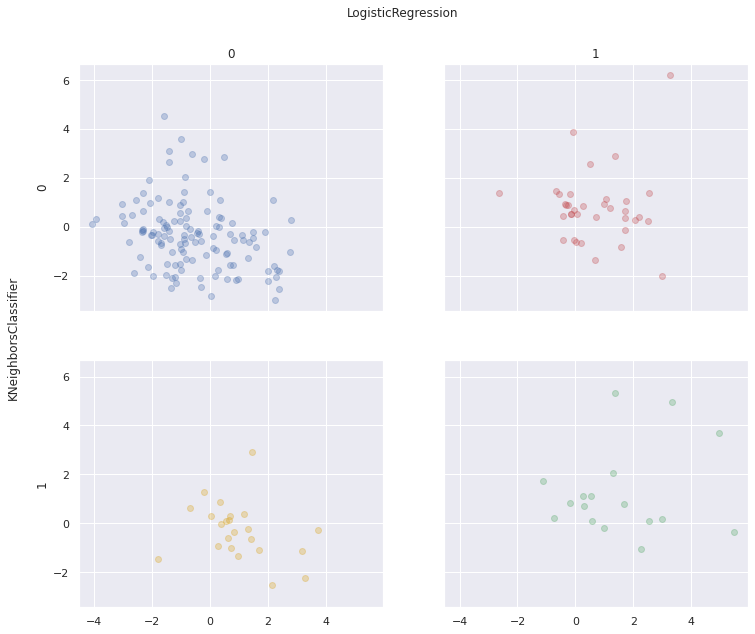

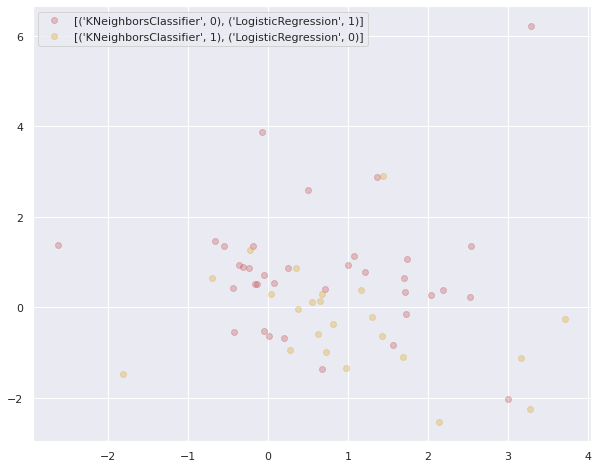

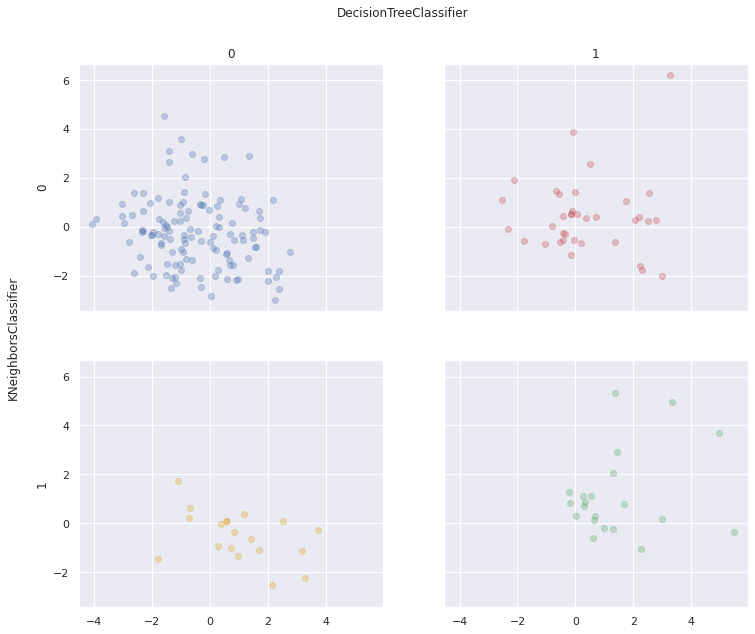

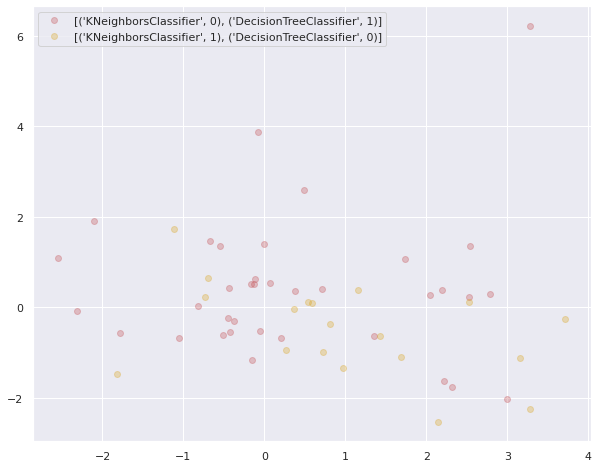

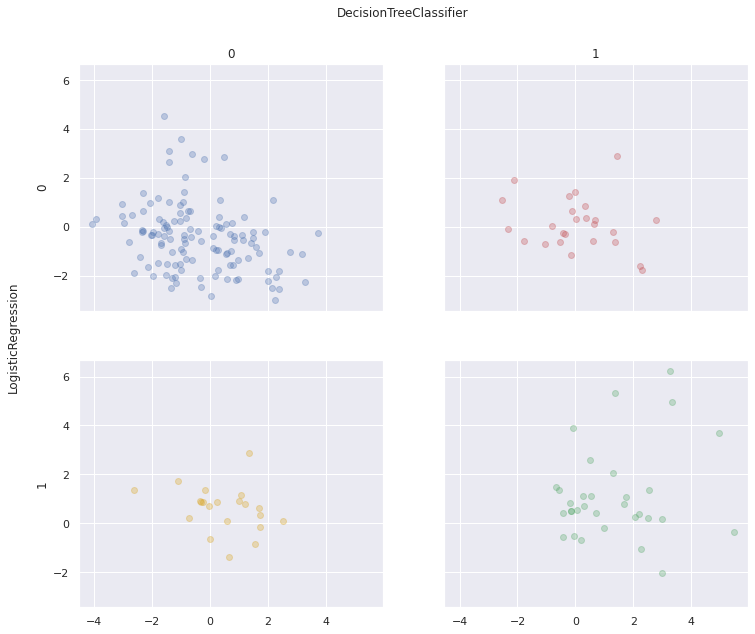

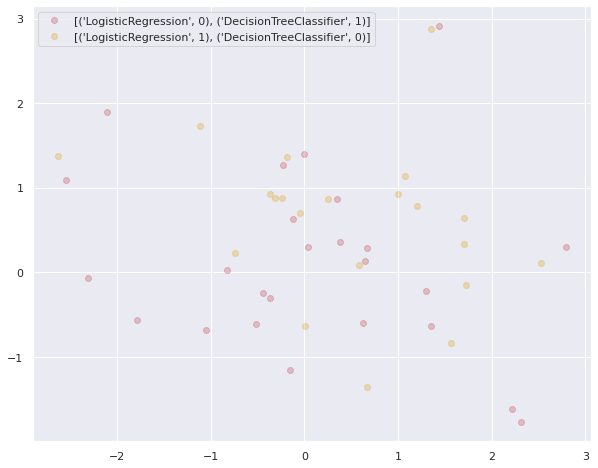

In [3]:
df = pd.read_csv('GermanCredit.csv')
X = df.values[:, :-1]
Y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)
Y1='KNeighborsClassifier', clf1.predict(X_test)
Y2='LogisticRegression', clf2.predict(X_test)
Y3='DecisionTreeClassifier', clf3.predict(X_test)

Y_list=[Y1,Y2,Y3]

X_st =  StandardScaler().fit_transform(X_test)
pca_scores = PCA(n_components=2).fit_transform(X_st)
X_DR=pd.DataFrame(pca_scores, columns=['DR1','DR2'])

MC_visual_confusion_matrix(X_DR, Y_list, export_file=True)

https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html

# MC_biplot

In [4]:
def MC_biplot(X_pca, pca_model, Y_list, filename=None):

    """
    Figure 5 in the paper performing pairwise comparison from a list of classifiers via Biplot.
    Example given below is for 3 binary classifiers.
    Input X of reduced dimensionality, pca model, and a list of tuples that consist of model_name and model_prediction
    
    cluster.biplot is from the following website: https://reneshbedre.github.io/blog/howtoinstall.html
    If need to save fig, change "show" to False.
    show: Show the figure on console instead of saving in current folder [True or False][default:False]
    Features along the direction of 01 and 10 predictions have more influences on 01 and 10 tradeoff.
    """ 
        
    df=pd.concat([pd.DataFrame(X_pca), pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1])], axis=1, ignore_index=True)
    df.columns=['DR1','DR2', Y_list[0][0], Y_list[1][0], Y_list[2][0]]

    loadings = pca_model.components_
    pca_model.explained_variance_

    for i1 in range(len(Y_list)):
        for i2 in range(i1+1,len(Y_list)):
            model1_name = Y_list[i1][0]
            model2_name = Y_list[i2][0]
            classes1 = np.unique(Y_list[i1][1])
            classes2 = np.unique(Y_list[i2][1])

            df2 = df[model1_name].astype(str) + df[model2_name].astype(str)
            relevant_observations = (df[model1_name]!=df[model2_name])
            target = df2[relevant_observations]
            df3 = df[['DR1','DR2']][relevant_observations]
            pca_scores = df3.to_numpy()

            print('MC_biplot '+ model1_name + ' vs. ' + model2_name)
            cluster.biplot(cscore=pca_scores, loadings=loadings, labels=features,
                           var1=round(pca_model.explained_variance_ratio_[0]*100, 2),
                           var2=round(pca_model.explained_variance_ratio_[1]*100, 2), colorlist=target,
                           show=True, dim=(12,10), valphadot=0.3, dotsize=15, arrowlinewidth=1.5,
                           arrowcolor='orange', axlabelfontsize=15, figtype='png',
                           colordot=['#e6b619', '#d65418']) #'#42b86d', '#1884d6'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


MC_biplot KNeighborsClassifier vs. LogisticRegression


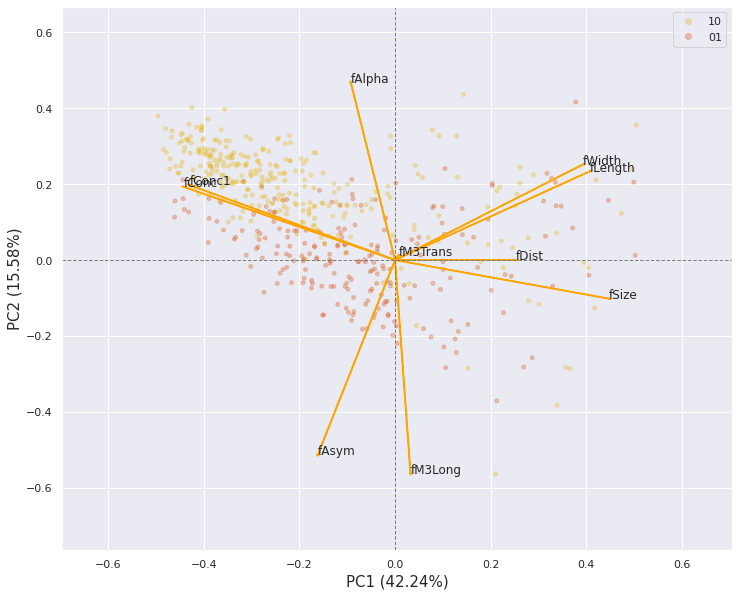

MC_biplot KNeighborsClassifier vs. DecisionTreeClassifier


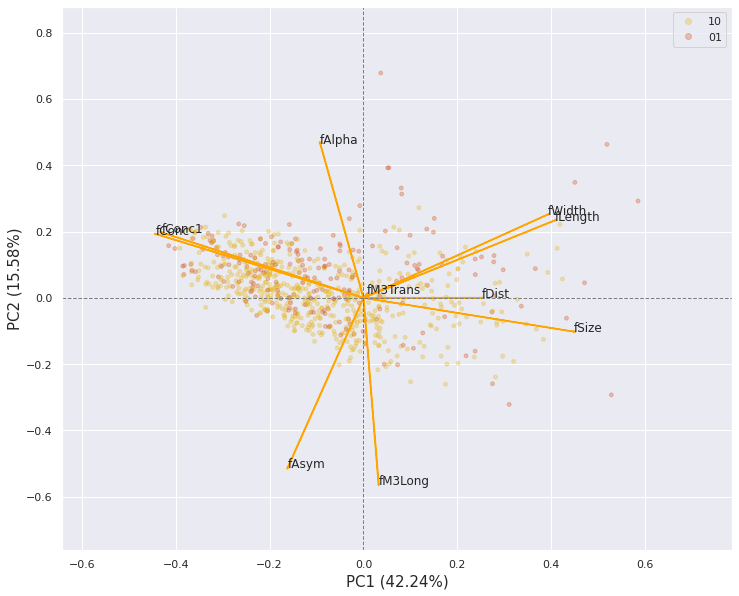

MC_biplot LogisticRegression vs. DecisionTreeClassifier


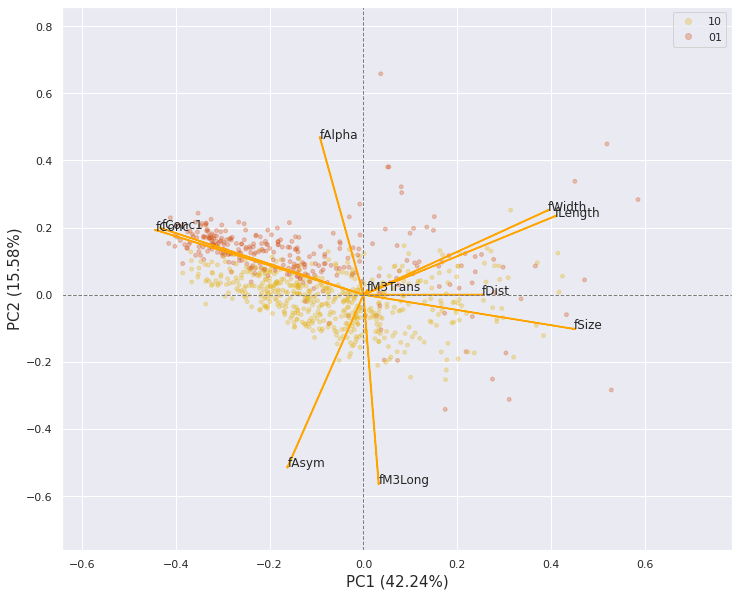

In [5]:
df = pd.read_csv('Magic.csv')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

features=X.columns.values
clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)
Y1='KNeighborsClassifier', clf1.predict(X_test)
Y2='LogisticRegression', clf2.predict(X_test)
Y3='DecisionTreeClassifier', clf3.predict(X_test)

Y_list=[Y1,Y2,Y3]

X_st =  StandardScaler().fit_transform(X_test)
pca_model = PCA(n_components=2).fit(X_st) #PCA().fit(X_st)
X_pca = PCA(n_components=2).fit_transform(X_st)


MC_biplot(X_pca, pca_model, Y_list, filename=None)

# Density plot visualization of the confusion matrix

In [6]:
def MC_visual_density_plot(X_DR, Y_list, filename=None):
    """
    Figure 6 in the paper performing pairwise comparison from a list of classifiers via density plot.
    Example given below is for 3 binary classifiers
    Input X of reduced dimensionality, and a list of tuples that consist of model_name and model_prediction
    """  
    df=pd.concat([X_DR, pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1])], axis=1, ignore_index=True)
    df.columns=['DR1','DR2', Y_list[0][0], Y_list[1][0], Y_list[2][0]]

    for i1 in range(len(Y_list)):
        for i2 in range(i1+1,len(Y_list)):
            model1_name = Y_list[i1][0]
            model2_name = Y_list[i2][0]
            classes1 = np.unique(Y_list[i1][1])
            classes2 = np.unique(Y_list[i2][1])

            df2 = df[model1_name].astype(str) + df[model2_name].astype(str)

            fig = plt.figure(figsize=[10,8])
            plt.xlim(-6, 6)
            plt.ylim(-6, 6)
            sns.kdeplot(data=df, x=df.DR1, y=df.DR2, hue=df2, fill=True, alpha=.6)
            plt.title(f'MC visual density plot {model1_name} vs. {model2_name}.png')
            plt.savefig(f'MC_visual_density_plot_{model1_name}_{model2_name}.png')

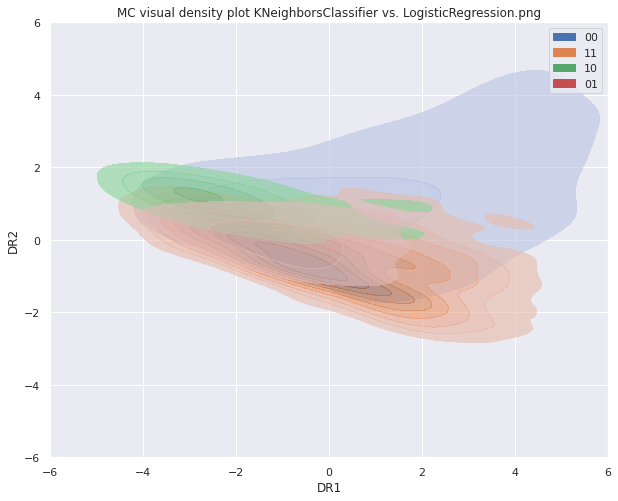

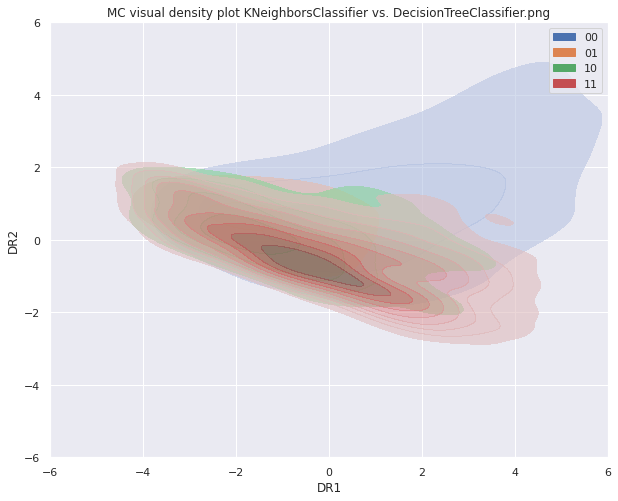

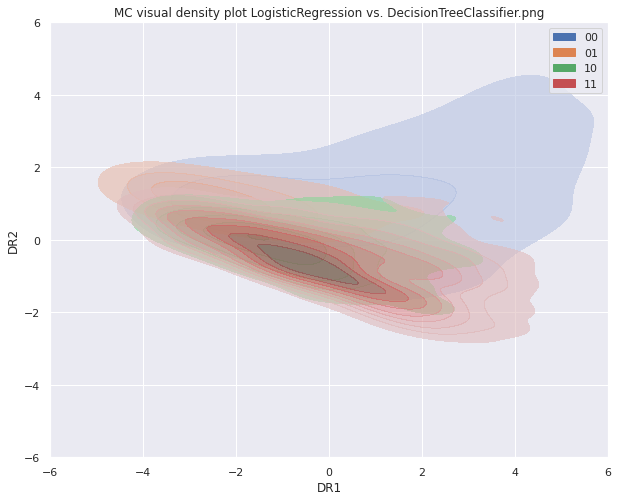

In [7]:
df = pd.read_csv('Magic.csv')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

features=X.columns.values
clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)
Y1='KNeighborsClassifier', clf1.predict(X_test)
Y2='LogisticRegression', clf2.predict(X_test)
Y3='DecisionTreeClassifier', clf3.predict(X_test)

Y_list=[Y1,Y2,Y3]

X_st =  StandardScaler().fit_transform(X_test)
pca_scores = PCA(n_components=2).fit_transform(X_st)
X_DR=pd.DataFrame(pca_scores, columns=['DR1','DR2'])

MC_visual_density_plot(X_DR, Y_list, filename=None)

# Simple DR comparison of labeled data

In [8]:
def MC_simple_dr_comparison(X_DR, Y_list, filename=None):
    
    """
    Figure 7 in the paper performing pairwise comparison from a list of classifiers by ploting models next to each other.
    The first subfigure shows the true y labels and serves as the baseline.
    Yellow markers represent observations with label (or prediction) 1
    Blue markers represent observations with label (or prediction) 0.
    Example given below is for 3 binary classifiers.
    Input X of reduced dimensionality and a list of tuples that consist of model_name and model_prediction
    """ 
        
    df=pd.concat([X_DR, pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1]), pd.DataFrame(Y_list[3][1])], axis=1, ignore_index=True)
    df.columns=['DR1','DR2', Y_list[0][0], Y_list[1][0], Y_list[2][0], Y_list[3][0]]

    classeslabel=np.unique(Y_list[0][1]).tolist()
    classes1 = np.unique(Y_list[1][1]).tolist()
    classes2 = np.unique(Y_list[2][1]).tolist()
    classes3 = np.unique(Y_list[3][1]).tolist()
    classifications=[classeslabel, classes1, classes2, classes3]

    fig = plt.figure(figsize=[10,10])
    for j2 in range(2,df.shape[1]):
        model=df.columns[j2]
        cl=classifications[j2-2]
        y=df[model]
        columnname=df.columns[j2]
        ax = fig.add_subplot(2,int(len(classifications)/2),j2-1)

        target_names = [model+' pos', model+' neg']
        colors = ['gold','steelblue']
        lw = 2

        for color, i, target_name in zip(colors, cl, target_names):
            ax.scatter(X_DR.iloc[:,0][y == i], X_DR.iloc[:,1][y == i], color=color, alpha=.3, lw=lw,label=target_name)
            ax.legend()
        fig.tight_layout(h_pad=2, w_pad=1)
    plt.show()
    plt.savefig(f'MC_simple_dr_comparison.png')
    

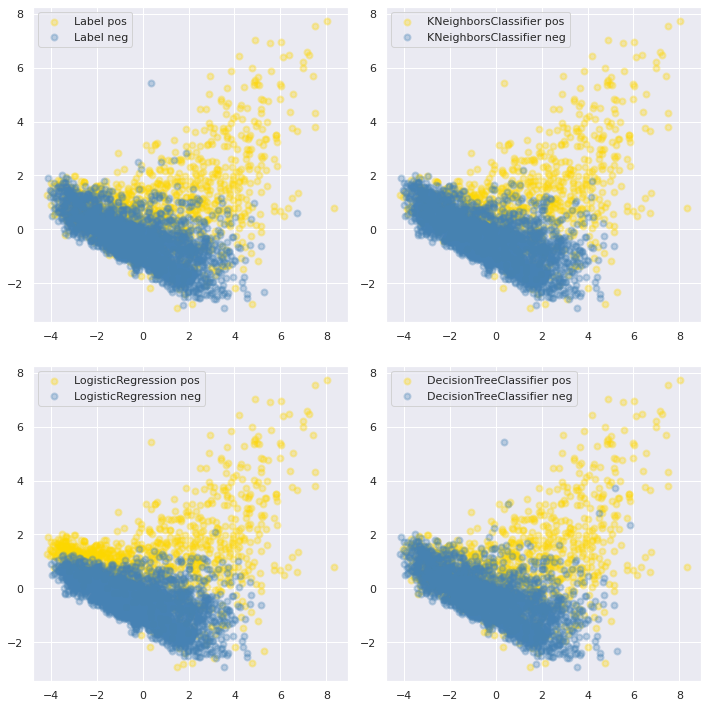

<Figure size 432x288 with 0 Axes>

In [9]:
df = pd.read_csv('Magic.csv')
X = df.values[:, :-1]
Y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)

Label='Label', y_test.astype(int)
Y1='KNeighborsClassifier', clf1.predict(X_test).astype(int)
Y2='LogisticRegression', clf2.predict(X_test).astype(int)
Y3='DecisionTreeClassifier', clf3.predict(X_test)
Y_list=[Label, Y1, Y2, Y3]

X_st =  StandardScaler().fit_transform(X_test)
pca_scores = PCA(n_components=2).fit_transform(X_st)
X_DR=pd.DataFrame(pca_scores, columns=['DR1','DR2'])

MC_simple_dr_comparison(X_DR, Y_list, filename=None)

# Heatmap of model predictions

In [10]:
def MC_heatmap_of_prediction(Y_list, filename=None):
    """
    Figure 2 in the paper performing pairwise comparison from a heatmap of model prediction agreement level.
    Example given below is for 3 binary classifiers.
    Input a list of tuples that consist of model_name and model_prediction
    ex. KNeighborsClassifier has accuracy 0.81 (81% agreement with true label),
    and agree with LogisticRegression on 86% of their predictions
    """ 
    df=pd.concat([pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1]), pd.DataFrame(Y_list[3][1])], axis=1, ignore_index=True)
    df.columns=[Y_list[0][0], Y_list[1][0], Y_list[2][0], Y_list[3][0]]

    n = df.shape[0]
    m = df.shape[1]
    res = np.zeros((m,m))
    for i1 in range(df.shape[1]):
        for i2 in range(df.shape[1]):
            acc = sum(df.iloc[:,i1]==df.iloc[:,i2])/n
            res[i1,i2]=acc

    res = pd.DataFrame(data=res, columns=df.columns.values, index=df.columns.values)
    res=res.round(2)

    fig = plt.figure(figsize=[4,3])
    ax = sns.heatmap(res, annot=True)
    plt.savefig(f'MC_heatmap_of_prediction.png')

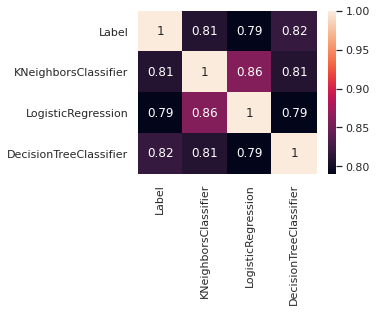

In [11]:
df = pd.read_csv('Magic.csv')
X = df.values[:, :-1]
Y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)

Label='Label', y_test.astype(int)
Y1='KNeighborsClassifier', clf1.predict(X_test).astype(int)
Y2='LogisticRegression', clf2.predict(X_test).astype(int)
Y3='DecisionTreeClassifier', clf3.predict(X_test).astype(int)

Y_list=[Label,Y1,Y2,Y3]

MC_heatmap_of_prediction(Y_list, filename=None)

# Scatter plot on model predictions

In [12]:
def MC_scatterplot_prediction(Y_list, filename=None):
    """
    Figure 9 in the paper performing pairwise comparison via plotting PCA dimensionality reduction on model predictions
    Example given below is for 3 binary classifiers.
    Input a list of tuples that consist of model_name and model_prediction
    Models locate close to each other have similar predictions
    Next to model names are prediction accuracies
    """
    
    df=pd.concat([pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1]), pd.DataFrame(Y_list[3][1])], axis=1, ignore_index=True)
    df.columns=[Y_list[0][0], Y_list[1][0], Y_list[2][0], Y_list[3][0]]

    df1=df.T
    indexnames=df1.index
    X = df1.values[:, :]
    pca = PCA(n_components=2,random_state=20)
    DR = pca.fit_transform(X)
    DR = pd.DataFrame(DR,columns=['DR1','DR2'], index=indexnames)

    label = [0,1,1,1]
    colors = ['green','coral']

    fig = plt.figure(figsize=[8,6])
    plt.scatter(x=DR['DR1'], y=DR['DR2'], c=label, cmap=matplotlib.colors.ListedColormap(colors))

    for i, txt in enumerate(DR.index):
        plt.annotate(txt, (DR['DR1'][i]-0.3, DR['DR2'][i]), ha='right')
        plt.annotate(Y_list[i][2], (DR['DR1'][i]+0.3, DR['DR2'][i]), ha='left')
    plt.show()
    plt.savefig(f'MC_scatterplot_prediction.png')

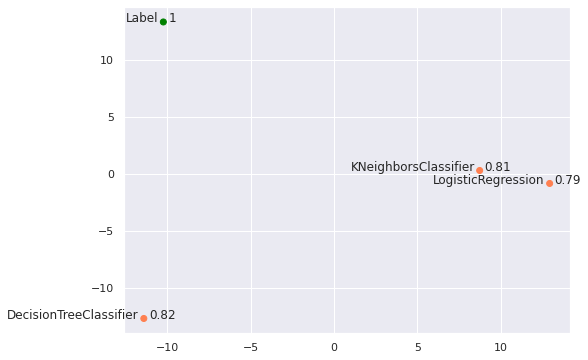

<Figure size 432x288 with 0 Axes>

In [13]:
df = pd.read_csv('Magic.csv')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)

Label='Label', y_test.astype(int).reset_index(drop=True), 1
Y1='KNeighborsClassifier', clf1.predict(X_test).astype(int),accuracy_score(y_test, pd.DataFrame(clf1.predict(X_test))).round(2)
Y2='LogisticRegression', clf2.predict(X_test).astype(int),accuracy_score(y_test, pd.DataFrame(clf2.predict(X_test))).round(2)
Y3='DecisionTreeClassifier', clf3.predict(X_test).astype(int),accuracy_score(y_test, pd.DataFrame(clf3.predict(X_test))).round(2)

Y_list=[Label,Y1,Y2,Y3]
MC_scatterplot_prediction(Y_list, filename=None)

# Scatter plot on confusion matrices

In [14]:
def MC_scatterplot_confusion(Y_list, filename=None):
    """
    Figure 11 in the paper performing pairwise comparison via plotting PCA dimensionality reduction on models' confusion matrices
    Example given below is for 3 binary classifiers.
    Input a list of tuples that consist of model_name and model_prediction
    Models locate close to each other have similar confusion matrices
    Next to confusion matrices names are model prediction accuracies
    """
    df=pd.concat([pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1]), pd.DataFrame(Y_list[3][1])], axis=1, ignore_index=True)
    df.columns=[Y_list[0][0], Y_list[1][0], Y_list[2][0], Y_list[3][0]]
    df.columns = [str(col) + '_vs_Label' for col in df.columns]

    for i in range(1,df.shape[1]):
        df.iloc[:,i] = df.iloc[:,i].astype(str) + df.iloc[:,0].astype(str)
    df['Label_vs_Label']= df['Label_vs_Label'].astype(str).str.repeat(2)  

    confusion=[]
    for j in range(0,df.shape[1]):
        df1 = pd.DataFrame(df.iloc[:,j].value_counts())
        confusion.append(df1)
        conf=pd.concat(confusion, axis=1).T
        conf[np.isnan(conf)]  = 0
        conf=conf.round().astype(int)

    indexnames=conf.index
    X = conf.values[:, :]
    X = StandardScaler().fit_transform(X)    #normalization
    pca = PCA(n_components=2,random_state=0)
    pca.fit(X)
    DR = pca.transform(X)
    DR = pd.DataFrame(DR,columns=['DR1','DR2'], index=indexnames)

    label = [0,1,1,1]
    colors = ['green','coral']

    fig = plt.figure(figsize=[8,6])
    plt.scatter(x=DR['DR1'], y=DR['DR2'], c=label, cmap=matplotlib.colors.ListedColormap(colors))

    for i, txt in enumerate(DR.index):
        plt.xlim(-4, 4)
        plt.ylim(-1.5, 1.5)
        plt.annotate(txt, (DR['DR1'][i]-0.2, DR['DR2'][i]), ha='right')
        plt.annotate(Y_list[i][2], (DR['DR1'][i]+0.2, DR['DR2'][i]), ha='left')
        fig.tight_layout(h_pad=2, w_pad=1)
    plt.show()
    plt.savefig(f'MC_scatterplot_confusion.png')

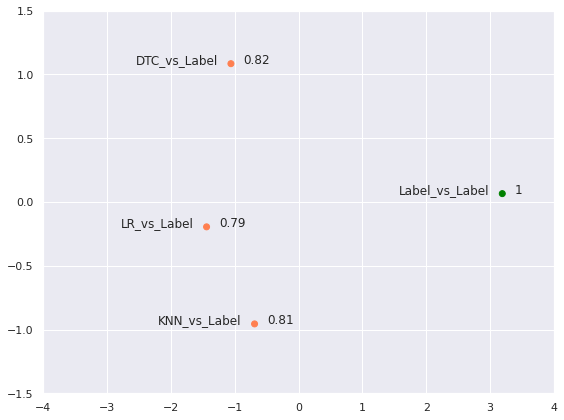

<Figure size 432x288 with 0 Axes>

In [15]:
df = pd.read_csv('Magic.csv')
X = df.values[:, :-1]
Y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)

Label='Label', y_test.astype(int), 1
Y1='KNN', clf1.predict(X_test).astype(int),accuracy_score(y_test, pd.DataFrame(clf1.predict(X_test))).round(2)
Y2='LR', clf2.predict(X_test).astype(int),accuracy_score(y_test, pd.DataFrame(clf2.predict(X_test))).round(2)
Y3='DTC', clf3.predict(X_test).astype(int),accuracy_score(y_test, pd.DataFrame(clf3.predict(X_test))).round(2)
Y_list=[Label,Y1,Y2,Y3]

MC_scatterplot_confusion(Y_list, filename=None)

# Tree visualization of models – hierarchical clustering

In [16]:
#Clustering on prediction
def plot_dendrogram(model, **kwargs):
    """
    Figure 12 in the paper performing model comparison via hierarchical clustering by prediction.
    Example given below is for 3 binary classifiers.
    Input a list of tuples that consist of model_name and model_prediction
    plot_dendrogram is from the following website: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    Models in the same cluster have similar predictions
    """ 
        
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

def MC_hierarchical_tree(Y_list, filename=None):
    df=pd.concat([pd.DataFrame(Y_list[0][1]), pd.DataFrame(Y_list[1][1]),pd.DataFrame(Y_list[2][1]), pd.DataFrame(Y_list[3][1])], axis=1, ignore_index=True)
    df.columns=[Y_list[0][0], Y_list[1][0], Y_list[2][0], Y_list[3][0]]

    clf = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    clf = clf.fit(df.T)
    fig = plt.figure(figsize=[12,5])
    plt.title('Hierarchical Clustering Dendrogram by Prediction')
    # plot the top three levels of the dendrogram
    plot_dendrogram(clf, truncate_mode=None, labels=df.columns)
    plt.show()
    plt.savefig(f'MC_hierarchical_tree.png')

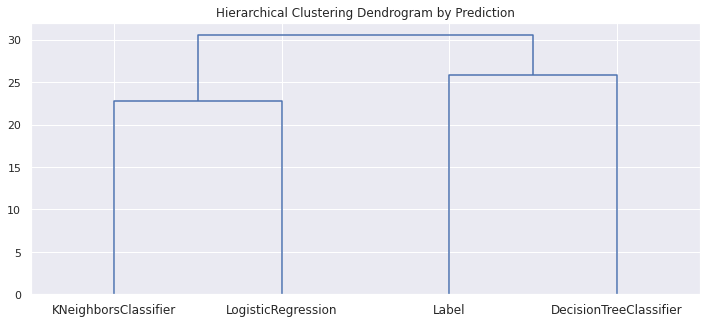

<Figure size 432x288 with 0 Axes>

In [17]:
df = pd.read_csv('Magic.csv')
X = df.values[:, :-1]
Y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

clf1=KNeighborsClassifier().fit(X_train, y_train)
clf2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf3=DecisionTreeClassifier().fit(X_train, y_train)

Label='Label', y_test.astype(int)
Y1='KNeighborsClassifier', clf1.predict(X_test).astype(int)
Y2='LogisticRegression', clf2.predict(X_test).astype(int)
Y3='DecisionTreeClassifier', clf3.predict(X_test).astype(int)
Y_list=[Label,Y1,Y2,Y3]

MC_hierarchical_tree(Y_list, filename=None)